<a href="https://colab.research.google.com/github/PROFESSORRQ/Real-Time-Haze-Removal-System/blob/main/haze_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

In [ ]:
cam= cv.VideoCapture(0)
cv2.nameWindow("test")
img_counter=0
while true:
  ret, frame=cam.read()
  if not ret:
    print("Failed to grab frame")
    break
  cv2.imshow("test",frame)

  k=cv2.waitkey(1)
  if k%256==27:
    print("Escpae hit. closing")
    break
  elif k%256==32:
    #space pressed
    img_name="opencv_frame_{}.png".format(img_counter)
    cv2.imwrite(img_name,frame)
    print("{} written!".format(img_name))
    img_counter+=1
cam.release()

cv2.destroyAllWindows()

NameError: ignored

In [ ]:
def bgr2rgb(img):
    b,g,r = cv.split(img)
    
    return cv.merge([r,g,b])

Here is a sample of a hazed image that we would be working with. The haze faintly obscures the foreground. We want to recover the unhazed image.

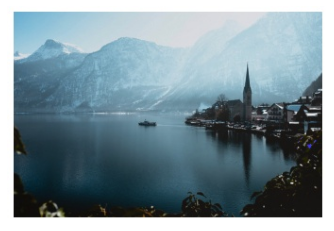

In [ ]:
img = bgr2rgb(cv.imread("hazee.jpg"))
plt.imshow(img)
plt.axis("off");

# New section

# New section

To model the formation of the hazed image, we use the equation 

$$I(x) = J(x)t(x) + A(1 - t(x))$$

where $I$ is the observed intensity, $J$ is the scene radiance, $A$ is the global atmospheric light, and $t$ is the medium transmission. Intuitively, the haze image is a linear combination of the scene radiance and scattered atmospheric light. If we can recover $A$ and $t$ from the hazed image, then we can use this model to solve for $J$, the unhazed image.

## Obtaining the Dark Channel Prior
The dark channel prior is defined as: $$J^{dark}(x) = \min_{c \in \{r,g,b\}}(\min_{y \in \Omega(x)}(J^{c}(y)))$$

$\mathbf{J}$ is our image, $J^{c}$ is defined as a color channel of our image (one of red, blue, or green), and $\Omega(x)$ is a patch of pixels centered at $x$. 

Intuitively, $J^{dark}$ should be low in a haze-free region of the image. Colorful objects will lack intensity in at least one color channel, resulting in a low $J^{dark}$. However, in the lighter colors in the sky regions of the image will have higher $J^{dark}$. We'll use this information later to estimate the atmospheric light.

The resulting dark channel prior from the image. In the foreground, the dark channel prior has low intensity, while in the sky regions, the intensity is high.

In [ ]:
def get_dark_channel_prior(img, w_size=10):
    """
    img    -> 3D tensor in RGB format
    w_size -> size of patch to consider (default is 15)
    """    
    J_dark = ndimage.minimum_filter(img, footprint=np.ones((w_size,w_size,3)), mode='nearest')
            
    return J_dark[:,:,1]

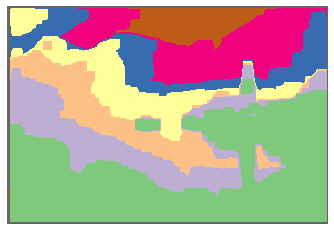

In [ ]:
tian_jdark = get_dark_channel_prior(img)
plt.imshow(tian_jdark, cmap='Accent')
plt.axis('off');

In [ ]:
def get_dark_channel_prior(img, w_size=7):
    """
    img    -> 3D tensor in RGB format
    w_size -> size of patch to consider (default is 15)
    """    
    J_dark = ndimage.minimum_filter(img, footprint=np.ones((w_size,w_size,3)), mode='nearest')
            
    return J_dark[:,:,1]

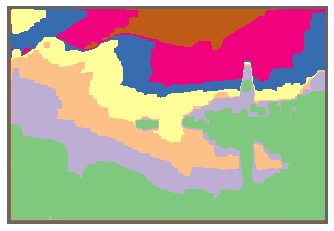

In [ ]:
tian_jdark = get_dark_channel_prior(img)
plt.imshow(tian_jdark, cmap='Accent')
plt.axis('off');

## Estimation of Atmospheric Light
We assume that the atmospheric light is a constant for each channel. Also, we calculate the atmospheric light for each channel in the image since Equation (6) from the paper references $A^{c}$, indicating that $A$ is different depending on what channel that is being used in the calculations.

The procedure is as follows:
1. Calculate the dark channel prior.
2. Pick the 0.1% brightest pixels in the dark channel.
3. Find the maximum intensity among the pixels in the original image $I$ for each of the channels.

A naive approach would be to simply take the highest intensities in all three color channels of the image and use that as the atmospheric light. However, this method is susceptible to incorrect results if there is a white object in the foreground. 

To circumvent this, we use the method of calculating the dark channel prior since it will limit our search for atmospheric light in the sky region of the image. 

In [ ]:
def estimate_atmospheric_light(img, w_size=15):
    """
    img -> 3D tensor in RGB format
    
    ret -> 
        A_r |
        A_g | -> estimated atmospheric light in the RGB channels
        A_c |
    """
    size = img.shape[:2]
    k = int(0.001*np.prod(size))
    j_dark = get_dark_channel_prior(img, w_size=w_size)
    idx = np.argpartition(-j_dark.ravel(),k)[:k]
    x, y = np.hsplit(np.column_stack(np.unravel_index(idx, size)), 2)
    
    A = np.array([img[x,y,0].max(), img[x,y,1].max(), img[x,y,2].max()])
    return A

Here, we replicate the detection of atmospheric light, similar to figure 7 (first row, third column). The pixels we inspect for the atmospheric light (shown in red) is in the same region as that of the paper's.

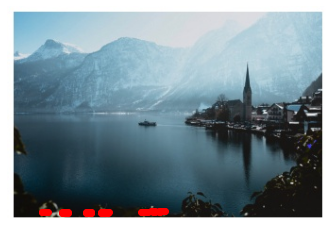

In [ ]:
size = img.shape[:2]
k = int(0.001*np.prod(size))
idx = np.argpartition(-tian_jdark.ravel(),k)[:k]
zz = np.column_stack(np.unravel_index(idx, tian_jdark.shape))
x, y = np.hsplit(zz,2)
plt.imshow(img)
plt.scatter(y, x, c='r')
plt.axis('off')
plt.show()

## Estimating the Transmission
We calculate the transmission $\bar{t}(x)$ through

$$\bar{t}(x) = 1 - \omega\min_{c \in \{r,g,b\}}(\min_{y \in \Omega(x)}(\frac{J^{c}(y)}{A^{c}}))$$

Intuitively, after normalizing the image using the atmospheric light, we know the fraction of atmospheric light that defines each pixel. From the model of the hazed image, we know that the hazed image is a linear combination of the atmospheric light and the original unhazed image. So, we can do 1 - this fraction to recover the fraction of the original image that defines each pixel.

In [ ]:
def estimate_transmission(img, omega=0.95, w_size=15):
    """
    Estimates the transmission map using the dark channel prior of the normalized image. 
    A small fraction, omega, of the haze is kept to retain depth perspective after haze removal.
    
    img   -> 3D Tensor in RGB format
    omega -> fraction of haze to keep in image (default is 0.95)
    """
    A= estimate_atmospheric_light(img)
    norm_img = img / A
    norm_img_dc = get_dark_channel_prior(norm_img, w_size=w_size)

    return 1 - omega*norm_img_dc

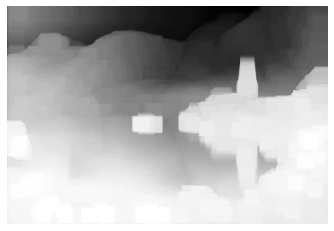

In [ ]:
alpha_map = estimate_transmission(img)
plt.imshow(alpha_map, cmap='gray')
plt.axis("off");

## Soft Matting
In this stage, we refine the alpha map to outline the profile of the objects in the image, allowing our transmission map to be correctly expressed. The paper uses a Matting Laplacian matrix to implement this refinement, but in another paper by the author he proposes a guided filter to achieve refinement. We will use this approach for our project.

We can vectorize the calculation of the guided filter by using two facts to calculate the covariance matrix for each patch:
1. $\Sigma_{ij} = cov(X_i, X_j) = \mathbb{E}[(X_i - \mu_i)(X_j - \mu_j)] = \mathbb{E}[X_iX_j] - \mu_i\mu_j$ [[1]](https://en.wikipedia.org/wiki/Covariance_matrix)
2. $\Sigma = \begin{bmatrix} \Sigma_{11} & \Sigma_{12} & \Sigma_{13} \\ \Sigma_{21} & \Sigma_{22} & \Sigma_{23} \\ \Sigma_{31} & \Sigma_{32} & \Sigma_{33}\end{bmatrix}$. Note that $\Sigma_{ij} = \Sigma_{ji}$.

This will generate the covariance matrix for each patch in equation (14) from [He et. al's guided filter paper](http://kaiminghe.com/publications/eccv10guidedfilter.pdf). With this done, the subsequent calculations are easy to implement.

Originally, we tried to use the Laplacian Soft Matting covered in the paper, but the implementation was too tedious. Further, the actual implementation of Laplacian Soft Matting is computationally inefficent. As we do **not** need an exact solution to the Matting Laplacian, and [He et. al's guided filter paper](http://kaiminghe.com/publications/eccv10guidedfilter.pdf) shows that the guided filter is an approximate solution, we chose not to implement it. The guided filter was easier to reason about and gave outstanding results in refining the transmission map.

Interestingly, in our testing there was little differnce between a guided filter based on the grayscale version of each photo vs using all 3 channels was minor. On some level this makes sense as most features can be distinguished clearly based on just intensity, however, it is clear that there can be boundaries that will be missed in some images due to foreground and background intensities blending together in the grayscale.

In [ ]:
def guided_filter(I, p, omega=60, eps=0.01):
    """
    from http://kaiminghe.com/publications/eccv10guidedfilter.pdf
    and  https://arxiv.org/pdf/1505.00996.pdf
    
    I     -> guidance image, 3D Tensor in RGB format
    p     -> filtering input image, 
    omega -> window size (default is 60)
    eps   -> regularization parameter (default 0.01)
    """
    
    w_size = (omega,omega)
    I = I/255
    I_r, I_g, I_b = I[:,:,0], I[:,:,1], I[:,:,2]
    
    mean_I_r = cv.blur(I_r, w_size)
    mean_I_g = cv.blur(I_g, w_size)
    mean_I_b = cv.blur(I_b, w_size)
    
    mean_p = cv.blur(p, w_size)
    
    mean_Ip_r = cv.blur(I_r*p, w_size)
    mean_Ip_g = cv.blur(I_g*p, w_size)
    mean_Ip_b = cv.blur(I_b*p, w_size)
         
    cov_Ip_r =  mean_Ip_r - mean_I_r*mean_p
    cov_Ip_g =  mean_Ip_g - mean_I_g*mean_p
    cov_Ip_b =  mean_Ip_b - mean_I_b*mean_p
    cov_Ip = np.stack([cov_Ip_r, cov_Ip_g, cov_Ip_b], axis=-1)
    
    var_I_rr = cv.blur(I_r*I_r, w_size) - mean_I_r*mean_I_r
    var_I_rg = cv.blur(I_r*I_g, w_size) - mean_I_r*mean_I_g
    var_I_rb = cv.blur(I_r*I_b, w_size) - mean_I_r*mean_I_b
    var_I_gb = cv.blur(I_g*I_b, w_size) - mean_I_g*mean_I_b
    var_I_gg = cv.blur(I_g*I_g, w_size) - mean_I_g*mean_I_g
    var_I_bb = cv.blur(I_b*I_b, w_size) - mean_I_b*mean_I_b
    
    a = np.zeros(I.shape)
    for x, y in np.ndindex(I.shape[:2]):
        Sigma = np.array([
            [var_I_rr[x,y], var_I_rg[x,y], var_I_rb[x,y]],
            [var_I_rg[x,y], var_I_gg[x,y], var_I_gb[x,y]],
            [var_I_rb[x,y], var_I_gb[x,y], var_I_bb[x,y]]
        ])
        c = cov_Ip[x,y,:]
        
        a[x,y,:] = np.linalg.inv(Sigma + eps*np.eye(3)).dot(c)
        
    mean_a = np.stack([cv.blur(a[:,:,0], w_size), cv.blur(a[:,:,1], w_size), cv.blur(a[:,:,2], w_size)], axis=-1)
    mean_I = np.stack([mean_I_r, mean_I_g, mean_I_b], axis=-1)
    
    b = mean_p - np.sum(a*mean_I, axis=2)
    mean_b = cv.blur(b, w_size)
    q = np.sum(mean_a*I, axis=2) + mean_b
    
    return q

f_alpha_map = guided_filter(img, alpha_map, omega=200, eps=1e-3)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))

ax1.imshow(alpha_map, cmap="gray")
ax1.set_title("Original")
ax1.axis('off')

ax2.imshow(f_alpha_map, cmap="gray")
ax2.set_title("w/ Guided Filter")
ax2.axis('off');

## Recovering the Scene Radiance
We now implement the full pipeline of haze removal.

In [ ]:
def haze_removal(img, w_size=15, a_omega=0.95, gf_w_size=200, eps=1e-6):
    """
    Implements the haze removal pipeline from 
    Single Image Haze Removal Using Dark Channel Prior by He et al. (2009)
    
    I       -> 3D tensor in RGB format
    w_size  -> window size of local patch (default is 15)
    a_omega -> fraction of haze to keep in image (default is 0.95)
    omega   -> window size for guided filter (default is 200)
    eps     -> regularization parameter for guided filter(default 1e-6)
    """
    img = img.astype(np.int16)
    A = estimate_atmospheric_light(img, w_size=w_size)
    alpha_map = estimate_transmission(img, omega=a_omega, w_size=w_size)
    f_alpha_map = guided_filter(img, alpha_map, omega=gf_w_size, eps=eps)
    
    img[:,:,0] -= A[0]
    img[:,:,1] -= A[1]
    img[:,:,2] -= A[2]
    z = np.maximum(f_alpha_map, 0.1)
    img[:,:,0] = img[:,:,0]/z
    img[:,:,1] = img[:,:,1]/z
    img[:,:,2] = img[:,:,2]/z

    img[:,:,0] += A[0]
    img[:,:,1] += A[1]
    img[:,:,2] += A[2]

    img = np.maximum(img, 0)
    img = np.minimum(img, 255)
    
    return img, f_alpha_map

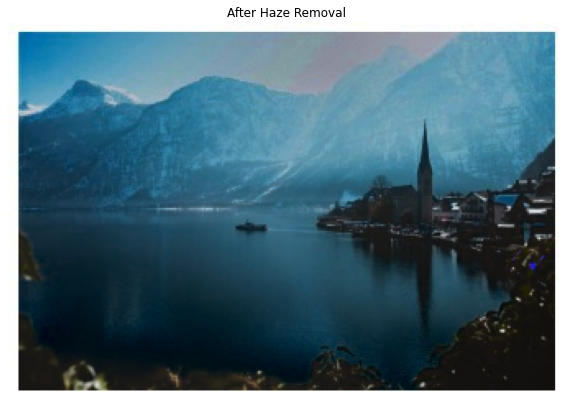

In [ ]:
l, _ = haze_removal(img, w_size=15, a_omega=0.95, gf_w_size=200, eps=1e-6)
f, ax2= plt.subplots(1, 1, figsize=(10,10))

# ax1.imshow(img)
# ax1.set_title("Original")
# ax1.axis('off')

ax2.imshow(l)
ax2.set_title("After Haze Removal")
ax2.axis('off');

We replicate our pipeline on the images used in [He's paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5206515&tag=1). The left column is the original image with haze, the middle column is the refined transmission map, generated from the dark channel prior and guided filter, and on the right is the image with the haze removed.

In [ ]:
import glob, os

for idx, file in enumerate(glob.glob("./images/*")):
    img = bgr2rgb(cv.imread(file))    
    dehazed, f_alpha_map = haze_removal(img)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
    ax1.imshow(img)
    ax1.axis("off")
    ax2.imshow(f_alpha_map, cmap="gray")
    ax2.axis("off")
    ax3.imshow(dehazed)
    ax3.axis("off")
    plt.show()

In [ ]:
# cap = cv2.VideoCapture("vtest.avi")
# ret, frame1 = cap.read()
# frame1 = haze_removal(bgr2rgb(frame1))
# prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
# hsv = np.zeros_like(frame1)
# hsv[...,1] = 255
# while(1):
#     ret, frame2 = cap.read()
#     next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
#     flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
#     mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
#     hsv[...,0] = ang*180/np.pi/2
#     hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
#     bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
#     cv2.imshow('frame2',bgr)
#     k = cv2.waitKey(30) & 0xff
#     if k == 27:
#         break
#     elif k == ord('s'):
#         cv2.imwrite('opticalfb.png',frame2)
#         cv2.imwrite('opticalhsv.png',bgr)
#     prvs = next
# cap.release()
# cv2.destroyAllWindows()